#MP4

In this assignment you will be performing Semantic Segmentation. We've provided the dataset and some helper code to guide you along.

Reminders:
- When first getting your code to run do not use GPU as this will exhaust your colab resources
- When you're ready to properly test your models, make sure you are connected to a GPU runtime as this does significantly speeds up execution
    - To change your runtime do: **Runtime** --> **Change runtime type** --> under **Hardware accelerator** select **GPU**
    - Note that changing runtime resets your kernel (meaning you will need to rerun cells and local variables will be lost)
    - It also sets this new runtime as the default when you return to this notebook later
- Do not start last minute, these models do take some time to train
- Loading the data takes some time, you should only have to do this once

## Accessing the data

There are multiple ways to work with data in colab.
See this [Colab notebook](https://colab.research.google.com/notebooks/io.ipynb) or this [StackOverflow post](https://stackoverflow.com/questions/48376580/google-colab-how-to-read-data-from-my-google-drive) for more details.

Once you've mounted your drive you can see your entire drive file structure by clicking the "Files" tab on the left.

**If you wish to work locally you can ignore the first two cells, but you will still need to set the appropriate path for your dataset**

In [1]:
!nvidia-smi

Tue Apr 12 01:01:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:1A:00.0 Off |                  Off |
| 31%   57C    P2    92W / 300W |   5092MiB / 49140MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    Off  | 00000000:1B:00.0 Off |                  Off |
| 30%   

In [2]:
DATASET_PATH = "../data/sbd/"

In [3]:
import glob
import os
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, average_precision_score, jaccard_score, ConfusionMatrixDisplay
import random

from PIL import Image
import torch
from torch import nn
from torch.utils import data
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import torchvision.transforms.functional as tf
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import torch.optim as optim
from scipy.sparse import coo_matrix

## Dataset (Q1)

Here we define a class (pytorch Dataset) for accessing data. This allows us to perform transformations on the data (data augmentation) as we access it. Pytorch dataloaders take in a dataset and conventiently deal with the overhead of looping through it in batches. Creating such datasets/loaders significantly simplifies our training code later on.

**PDF: In your pdf visualize the same image (your choice which) a couple times to demonstrate your transformations**



In [4]:
class RandomHorizontalFlip(object):
    def __init__(self, p):
        self.p = p

    def __call__(self, sample):
        img, mask = sample
        if np.random.random() < self.p:
            img = tf.hflip(img)
            mask = tf.hflip(mask)

        return img, mask

class RandomCrop(object):
    def __init__(self, size, *args, **kwargs):
        self.size = size
        self.random_crop = transforms.RandomResizedCrop(size, *args, **kwargs)

    def __call__(self, sample):
        img, mask = sample
        i, j, h, w = self.random_crop.get_params(img, scale=(0.75, 1.0), ratio=(0.75, 1.3333333333333333))
        img = tf.resized_crop(img, i, j, h, w, size=self.size)
        mask = tf.resized_crop(mask, i, j, h, w, size=self.size)

        return img, mask

class CenterCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, sample):
        img, mask = sample
        img = tf.center_crop(img, output_size=self.size)
        mask = tf.center_crop(img, output_size=self.size)

        return img, mask


class ToTensor(object):
    def __init__(self):
        pass

    def __call__(self, sample):
        img, mask = sample
        img = tf.to_tensor(img)
        mask = torch.as_tensor(np.array(mask), dtype=torch.int64)

        if len(mask.shape) == 3 and mask.size(0) == 1:
            mask = mask.squeeze(0)

        return img, mask

In [5]:
class SegmentationDataset(data.Dataset):
    """
    Data loader for the Segmentation Dataset. If data loading is a bottleneck, 
    you may want to optimize this in for faster training. Possibilities include
    preloading all images and annotations into memory before training, to limit delays due to disk reads.
    """
    def __init__(self, split="train", preload=True, data_dir=DATASET_PATH, transform=False):
        assert(split in ["train", "val", "test"])
        self.img_dir = os.path.join(data_dir, split)
        self.classes = []
        with open(os.path.join(data_dir, 'classes.txt'), 'r') as f:
            for l in f:
                self.classes.append(l.rstrip())
        self.n_classes = len(self.classes)
        self.split = split
        self.data = glob.glob(self.img_dir + '/*.jpg') 
        self.data = [os.path.splitext(l)[0] for l in self.data]
        self.enable_transform = transform
        self.train_transform = transforms.Compose([
            RandomHorizontalFlip(p=0.5),
            RandomCrop(size=(224, 288)),
        ])
        self.to_tensor = ToTensor()
        self.preload = preload
        # preload data
        if preload:
            self.images = [Image.open(self.data[index] + '.jpg') for index in range(len(self.data))]
            self.ground_truth = [Image.open(self.data[index] + '.png') for index in range(len(self.data))]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if self.preload:
            img = self.images[index]
            gt = self.ground_truth[index]
        else:
            img = Image.open(self.data[index] + '.jpg')
            gt = Image.open(self.data[index] + '.png')

        # Question 1: data augmentation
        # hint: how does transforming the image affect the ground truth?
        # Note: your transformation should not change the image dimensions    
        if self.enable_transform and self.split == "train":
            # Your code
            # -------------------------
            img, gt = self.train_transform((img, gt))
            # -------------------------
        img, gt = self.to_tensor((img, gt))

        gt = torch.LongTensor(np.array(gt)).unsqueeze(0)

        return img, gt

In [6]:
# TODO: set the batch size, when running experiments later you should try different batch sizes
training_batch_size = 64
dataset = SegmentationDataset(split="train", preload=False, data_dir=DATASET_PATH, transform=False)
dataloader = data.DataLoader(dataset, batch_size=training_batch_size, shuffle=True, num_workers=os.cpu_count(), drop_last=True)

In [7]:
val_dataset = SegmentationDataset(split="val", preload=False, data_dir=DATASET_PATH, transform=False)
val_dataloader = data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=os.cpu_count(), drop_last=False)

In [8]:
def view_image(idx):
    img = dataset[idx]
    _, axes = plt.subplots(1,2)
    axes[0].imshow(np.swapaxes(np.swapaxes(img[0], 0, 2), 0, 1))
    axes[1].imshow(img[1][0])
    plt.show()

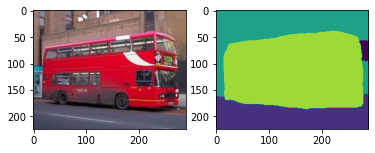

In [9]:
# You might want to look at a bunch of different images to get a feel for your data
view_image(random.randint(0, len(dataset)))

## Simple Baseline (Q2)

This is a trivial semantic segmentor. For each pixel location it computes the 
distribution of the class label in the training set and uses that as the 
prediction. In other words, if a pixel is "sky" half the time and "water" the other half in the training data, you should label it as [0.5,0,0,0,0.5,0,0,0,0].

**PDF: in your pdf report the evaluation metrics (from the next question) for this simple baseline. Also visualize the output image of simple_predict (since simple_predict outputs the same segmentation regardless of input you can just report a single image)**

In [10]:
# Question 2
# Output shape: (num_classes, 224, 288)
def simple_train(num_classes, train_dataloader):
    # Your code
    # -------------------------
    masks = []
    for _, mask in train_dataloader:
        masks.append(mask)
    masks = torch.concat(masks, dim=0).squeeze(1)
    model = torch.stack([(masks == k).sum(dim=0) for k in range(num_classes)], dim=0)
    # -------------------------
    return model

# Output:
#   gt: the ground truth segmentation, shape (dataset_size, 1, 224, 288)
#   pred: the predicted segmentation class probabilities, shape (dataset_size, 9, 224, 288)
def simple_predict(pred_dataloader, model):
    simple_gts, simple_preds = [], []
    for _, batch in enumerate(tqdm(pred_dataloader)):
        # Your code
        # -------------------------
        img, gt = batch
        simple_gts.append(gt.numpy())
        simple_preds.extend([model.numpy() / model.sum(axis=0).numpy()] * len(gt))
        # -------------------------

    return np.concatenate(simple_gts, axis=0), np.stack(simple_preds, axis=0)

In [11]:
# our "model" is class frequency, train it then make predictions for the validation set
dataset.enable_transform = False
class_freq = simple_train(dataset.n_classes, dataloader)
gts, preds = simple_predict(val_dataloader, class_freq)
classes = list(dataset.classes)
dataset.enable_transform = True

  0%|          | 0/5 [00:00<?, ?it/s]

In [12]:
preds.shape

(72, 9, 224, 288)

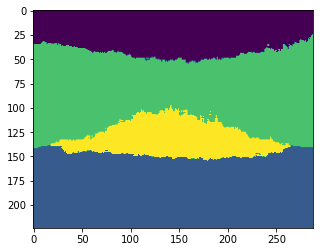

In [63]:
# visualize the output segmentation prediction
plt.imshow(np.argmax(preds[0], axis=0))
plt.savefig("../results/simple_predict.pdf", dpi=500)

## Evaluation Metrics (Q3)

We've implemented mean average precision. Your job is to compute the confusion matrix and IoU for a set of predictions. Namely, fill in the compute_confusion_matrix function.

The **(i,j)**th entry of a confusion matrix computes the number of observations known to be in group **i** and predicted to be in group **j**. You can use [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) as a reference and sanity check.

IoU is the intersection of the predicted and ground truth segmentation masks divided by their union. Think how these values are related to what you've already computed in the confusion matrix. 

In [14]:
def segmentation_eval(gts, preds, classes, plot_file_name):
    """
    @param    gts               numpy.ndarray   ground truth labels
    @param    preds             numpy.ndarray   predicted labels
    @param    classes           string          class names
    @param    plot_file_name    string          plot file names
    """
    ious, counts = compute_confusion_matrix(gts, preds)
    aps = compute_ap(gts, preds)
    plot_results(counts, ious, aps, classes, plot_file_name)
    for i in range(len(classes)):
        print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format(classes[i], aps[i], ious[i]))
    print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format('mean', np.mean(aps), np.mean(ious)))
    return aps, ious

def plot_results(counts, ious, aps, classes, file_name):
    fig, ax = plt.subplots(1,1)
    conf = counts / np.sum(counts, 1, keepdims=True)
    conf = np.concatenate([conf, np.array(aps).reshape(-1,1), 
                           np.array(ious).reshape(-1,1)], 1)
    conf = conf * 100.
    sns.heatmap(conf, annot=True, ax=ax, fmt='3.0f') 
    arts = [] 
    # labels, title and ticks
    _ = ax.set_xlabel('Predicted labels')
    arts.append(_)
    _ = ax.set_ylabel('True labels')
    arts.append(_)
    _ = ax.set_title('Confusion Matrix, mAP: {:5.1f}, mIoU: {:5.1f}'.format(
      np.mean(aps)*100., np.mean(ious)*100.))
    arts.append(_)
    _ = ax.xaxis.set_ticklabels(classes + ['AP', 'IoU'], rotation=90)
    arts.append(_)
    _ = ax.yaxis.set_ticklabels(classes, rotation=0)
    arts.append(_)
    fig.savefig(file_name, bbox_inches='tight')
    plt.show()

def compute_ap(gts, preds):
    aps = []
    for i in range(preds.shape[1]):
        ap, prec, rec = calc_pr(gts == i, preds[:,i:i+1,:,:])
        aps.append(ap)
    return aps

def calc_pr(gt, out, wt=None):
    gt = gt.astype(np.float64).reshape((-1,1))
    out = out.astype(np.float64).reshape((-1,1))
    tog = np.concatenate([gt, out], axis=1)*1.
    ind = np.argsort(tog[:,1], axis=0)[::-1]
    tog = tog[ind,:]
    cumsumsortgt = np.cumsum(tog[:,0])
    cumsumsortwt = np.cumsum(tog[:,0]-tog[:,0]+1)
    prec = cumsumsortgt / cumsumsortwt
    rec = cumsumsortgt / np.sum(tog[:,0])
    ap = voc_ap(rec, prec)
    return ap, rec, prec

def voc_ap(rec, prec):
    rec = rec.reshape((-1,1))
    prec = prec.reshape((-1,1))
    z = np.zeros((1,1)) 
    o = np.ones((1,1))
    mrec = np.vstack((z, rec, o))
    mpre = np.vstack((z, prec, z))

    mpre = np.maximum.accumulate(mpre[::-1])[::-1]
    I = np.where(mrec[1:] != mrec[0:-1])[0] + 1
    ap = np.sum((mrec[I] - mrec[I - 1]) * mpre[I])
    return ap
    
# Question 3: compute the confusion matrix and IoU metrics for each class
# Hint: once you've computed the confusion matrix, IoU is easy
# Note: preds contains class probabilities, convert this to a class prediction
def compute_confusion_matrix(gt, pred):
    # Your code
    gt = gt.reshape(-1)
    pred = pred.argmax(axis=1).reshape(-1)
    cm = coo_matrix((np.ones_like(pred, dtype=np.uint8), (gt, pred)), shape=(9, 9), dtype=np.uint64).toarray()
    cm = np.nan_to_num(cm)

    intersection = np.diag(cm)
    union = cm.sum(axis=0) + cm.sum(axis=1) - intersection
    iou = intersection / union

    return iou, cm

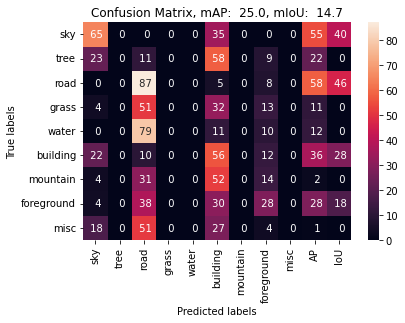

                 sky: AP: 0.55, IoU: 0.40
                tree: AP: 0.22, IoU: 0.00
                road: AP: 0.58, IoU: 0.46
               grass: AP: 0.11, IoU: 0.00
               water: AP: 0.12, IoU: 0.00
            building: AP: 0.36, IoU: 0.28
            mountain: AP: 0.02, IoU: 0.00
          foreground: AP: 0.28, IoU: 0.18
                misc: AP: 0.01, IoU: 0.00
                mean: AP: 0.25, IoU: 0.15


In [15]:
# Evaluate our trivial segmentor
aps, ious = segmentation_eval(gts, preds, classes, '../results/simple-train.pdf')

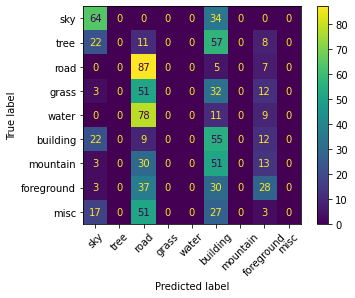

In [16]:
ConfusionMatrixDisplay((confusion_matrix(y_pred=preds.argmax(axis=1).reshape(-1), y_true=gts.reshape(-1), normalize="true") * 100).astype(int), display_labels=classes).plot(xticks_rotation=45)

In [17]:
jaccard_score(y_pred=preds.argmax(axis=1).reshape(-1), y_true=gts.reshape(-1), average=None)

array([0.40130266, 0.        , 0.46086023, 0.        , 0.        ,
       0.28105439, 0.        , 0.17928937, 0.        ])

## Loss function (Q4)

Implement the weighted cross entropy loss. 

You may not call nn.CrossEntropy but can use it as a good reference and sanity check.

**PDF: in your pdf please describe the cross entropy loss. Also explain the purpose of using a weighted loss.**

In [18]:
def cross_entropy_criterion(predictions, labels, weights):
    # your code
    log_probs = F.log_softmax(predictions, dim=1)
    weights = weights[labels]
    loss = - weights * log_probs.gather(index=labels, dim=1)
    loss /= weights.sum()

    return loss.sum()

In [19]:
probs_rand = torch.rand(16, 10, 32, 32)
gts_rand = torch.randint(0, 10, (16, 1, 32, 32))
w = torch.tensor([0.1, 0.2, 0.3, 0.2, 0.2, 0, 0, 0, 0, 0])

print(cross_entropy_criterion(probs_rand, gts_rand, w))
print(F.cross_entropy(probs_rand, gts_rand[:, 0, ...], weight=w, reduction="mean"))

tensor(2.3408)
tensor(2.3408)


## Training loop (Q5)

Fill in the training loop. We've provided validation code as well as skeleton code for training.

Keep in mind that you need to move data onto the device (GPU) as you cycle through the dataloader

While we've provided you with a skeleton to fill in, you should feel free to modify the visualization code for debugging purposes. For example you might want to print out the loss each iteration instead of once per epoch. Or you might want to compute validation accuracy metrics (like IoU) instead of just validation loss.

**PDF: in your pdf please describe why it is important to consider both validation and training losses simultaneously. When loss stops decreasing, can we change something about the training parameters to continue improving the model?**

In [20]:
@torch.no_grad()
def validate_model(val_loader, model, class_names, dev, show_matrix=False):
    preds = np.array([]).reshape(0, 9, 224, 288)
    gts = np.array([]).reshape(0, 1, 224, 288)
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs = inputs.to(dev)

            outputs = model(inputs)
            if isinstance(outputs, dict):
                outputs = outputs["out"]
            outputs = outputs.cpu().numpy()
            preds = np.concatenate([preds, outputs], axis=0)
            gts = np.concatenate([gts, labels.numpy()], axis=0)
            
            print("Validating...{}\r".format(100.0 * len(preds) / len(val_loader)), end="")
    
    if show_matrix:
        _ = segmentation_eval(gts, preds, class_names, '../results/cs543-simple-val_3.pdf')
    else:
        iou, counts = compute_confusion_matrix(gts, preds)
        ap = compute_ap(gts, preds)
        for k in range(len(class_names)):
            print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format(class_names[k], ap[k], iou[k]))
        print('{:>20s}: AP: {:0.2f}, IoU: {:0.2f}'.format('mean', np.mean(ap), np.mean(iou)))

    return preds, gts

# Your goal is to complete this function
def train(model, opt, loss, train_loader, dev, val_loader=None, num_epochs=15):
    train_loss_over_epochs = []
    val_loss_over_epochs = []
    plt.ioff()
    fig = plt.figure()
    for epoch in tqdm(range(num_epochs), total=num_epochs):
        # running loss is the **average** loss for each item in the dataset during this epoch
        running_loss = 0.0
        model.train()
        for _, (img, y_true) in enumerate(train_loader, 0):
            # Your code
            # -------------------------
            img = img.to(dev)
            y_true = y_true.to(dev)
            
            if isinstance(loss, nn.CrossEntropyLoss):
                y_true = y_true.squeeze(1)

            y_pred = model(img)
            batch_loss = loss(y_pred, y_true)

            optimizer.zero_grad()
            batch_loss.backward()
            opt.step()

            running_loss += batch_loss.item()
            # -------------------------

        running_loss /= len(train_loader)
        train_loss_over_epochs.append(running_loss)
        # Note: it can be more readable to overwrite the previous line - end="\r"
        print('Epoch: {}, training loss: {:.3f}'.format(epoch + 1, running_loss))

        # If you pass in a validation dataloader then compute the validation loss
        if not val_loader is None:
            val_loss = 0.0
            model.eval()
            with torch.no_grad():
                for img, y_true in val_loader:
                    # Your code
                    # -------------------------
                    img = img.to(dev)
                    y_true = y_true.to(dev)
                    if isinstance(loss, nn.CrossEntropyLoss):
                        y_true = y_true.squeeze(1)
                    y_pred = model(img)

                    val_loss += loss(y_pred, y_true).item()
                    # -------------------------
            val_loss /= len(val_loader)
            val_loss_over_epochs.append(val_loss)
            print('Epoch: {}, training loss: {:.3f}'.format(epoch + 1, val_loss))
        
    plt.subplot(2, 1, 1)
    plt.ylabel('Loss')
    plt.plot(np.arange(num_epochs), train_loss_over_epochs, color='red', label='train')
    if not val_loader is None:
        plt.plot(np.arange(num_epochs), val_loss_over_epochs, color='blue', label='val')
    plt.title('Loss per Epoch')
    plt.xticks(np.arange(num_epochs, dtype=int))
    plt.grid(True)
    plt.legend()
    plt.show()

    return model

## Model definitions (Q6)

Now create your models. Create one basic Convolutional architecture and one U-Net architecture.

We provide some helpful methods below to compute the size of your next convolutional layer (you can find these formula at TODO).

Some things to keep in mind:
- your basic layer is nn.Conv2D, read its documentation
- for UNet you will also need nn.ConvTranspose2D and Pooling layers
- nn.BatchNorm2d is incredibly helpful between layers
- you can stick to ReLU activations, but are welcome to report results with other activation functions

**PDF: in your pdf please describe your final model architectures. Report the training plots and final accuracy metrics on the validation set for each model. What batch size, learning rate, optimizer did you find works best. Perform a small ablation study: what is the effect of batchnorm on training speed and accuracy? Visualize a few images and their predicted segmentation masks by your UNet model.**

In [21]:
def conv_out_size(inp_size, kernel_size, dilation, padding, stride):
    return ((inp_size + 2 * padding - dilation * (kernel_size - 1) - 1) // stride) + 1

def conv_trans_out_size(inp_size, kernel_size, dilation, padding, stride, out_padding):
    return (inp_size - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + out_padding + 1

In [58]:
class BaseConv(nn.Module):
    def __init__(self):
        super(BaseConv, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 9, kernel_size=1),
        )

    def forward(self, x):
        x = self.conv(x)
        
        return x

In [23]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = self.double_conv(x)
        return out


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class Conv1x1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv1x1, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [24]:
class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        self.n_classes = n_classes

        self.conv = DoubleConv(3, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        self.down4 = Down(128, 256)
        self.up1 = Up(256, 128)
        self.up2 = Up(128, 64)
        self.up3 = Up(64, 32)
        self.up4 = Up(32, 16)
        self.clf = Conv1x1(16, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.clf(x)
        
        return logits

### Now we can finally train our models...

In [25]:
# if runtime has GPU use GPU
if torch.cuda.is_available():
    device = torch.device("cuda:9")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda:1


In [26]:
# For the weighted cross entropy loss we can compute class weights using our simple baseline
class_freq = simple_train(dataset.n_classes, dataloader)
class_weights = []
for i in range(9):
    class_weights.append(1 / np.mean(class_freq[i, :, :].numpy()))
class_weights = torch.tensor(class_weights, device=device).float()
print(class_weights)

tensor([0.0140, 0.0137, 0.0091, 0.0272, 0.0510, 0.0087, 0.1310, 0.0130, 0.4375],
       device='cuda:1')


### Basic convolutional model training

In [27]:
dataset = SegmentationDataset(split="train", preload=False, data_dir=DATASET_PATH, transform=True)
dataloader = data.DataLoader(dataset, batch_size=training_batch_size, shuffle=True, num_workers=os.cpu_count(), drop_last=True)

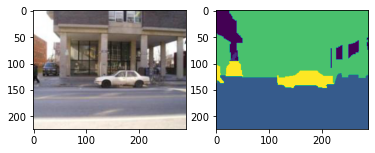

In [28]:
view_image(random.randint(0, len(dataset)))

In [61]:
# # First make the model and put it on the device
base_model = BaseConv().to(device)

# # Now define our loss criterion as cross entropy based on your previous code
# criterion = nn.CrossEntropyLoss(weight=class_weights.to(device).clone().detach())
criterion = lambda y_pred, y_true: cross_entropy_criterion(y_pred, y_true, class_weights)

# # Now make our optimizer for this model
# # TODO: pick an optimizer from torch.optim and set the learning rate
lr = 0.01
optimizer = torch.optim.AdamW(params=base_model.parameters(), lr=lr, weight_decay=5e-4)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, training loss: 1.941
Epoch: 1, training loss: 2.397
Epoch: 2, training loss: 1.718
Epoch: 2, training loss: 2.035
Epoch: 3, training loss: 1.679
Epoch: 3, training loss: 1.955
Epoch: 4, training loss: 1.645
Epoch: 4, training loss: 1.977
Epoch: 5, training loss: 1.632
Epoch: 5, training loss: 1.735
Epoch: 6, training loss: 1.612
Epoch: 6, training loss: 2.044
Epoch: 7, training loss: 1.591
Epoch: 7, training loss: 1.729
Epoch: 8, training loss: 1.549
Epoch: 8, training loss: 1.790
Epoch: 9, training loss: 1.542
Epoch: 9, training loss: 1.761
Epoch: 10, training loss: 1.593
Epoch: 10, training loss: 1.763
Epoch: 11, training loss: 1.546
Epoch: 11, training loss: 1.833
Epoch: 12, training loss: 1.514
Epoch: 12, training loss: 1.750
Epoch: 13, training loss: 1.492
Epoch: 13, training loss: 1.865
Epoch: 14, training loss: 1.501
Epoch: 14, training loss: 1.748
Epoch: 15, training loss: 1.479
Epoch: 15, training loss: 1.666
Epoch: 16, training loss: 1.502
Epoch: 16, training loss: 

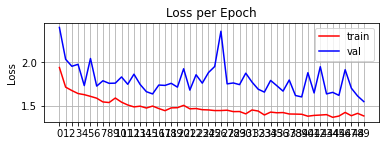

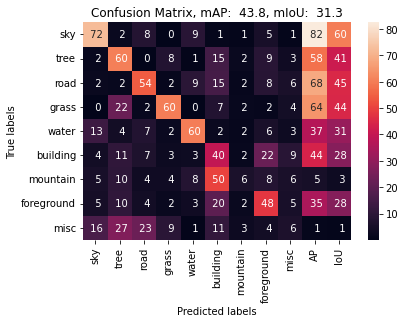

                 sky: AP: 0.82, IoU: 0.60
                tree: AP: 0.58, IoU: 0.41
                road: AP: 0.68, IoU: 0.45
               grass: AP: 0.64, IoU: 0.44
               water: AP: 0.37, IoU: 0.31
            building: AP: 0.44, IoU: 0.28
            mountain: AP: 0.05, IoU: 0.03
          foreground: AP: 0.35, IoU: 0.28
                misc: AP: 0.01, IoU: 0.01
                mean: AP: 0.44, IoU: 0.31


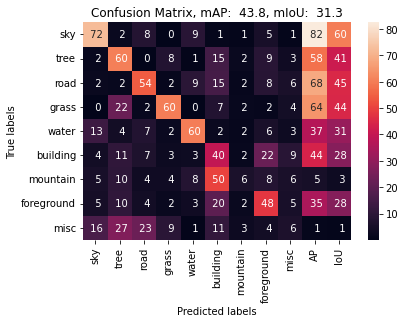

                 sky: AP: 0.82, IoU: 0.60
                tree: AP: 0.58, IoU: 0.41
                road: AP: 0.68, IoU: 0.45
               grass: AP: 0.64, IoU: 0.44
               water: AP: 0.37, IoU: 0.31
            building: AP: 0.44, IoU: 0.28
            mountain: AP: 0.05, IoU: 0.03
          foreground: AP: 0.35, IoU: 0.28
                misc: AP: 0.01, IoU: 0.01
                mean: AP: 0.44, IoU: 0.31


([0.8249286192369744,
  0.579553798103864,
  0.6842540128008342,
  0.6417126227554055,
  0.36967692093838106,
  0.4351684193659098,
  0.04915638548734403,
  0.3495551491800583,
  0.010634052314586777],
 array([0.60194791, 0.41434399, 0.44969909, 0.44481799, 0.310494  ,
        0.28045625, 0.03009132, 0.27572666, 0.0092995 ]))

In [62]:
# # Now train and validate
# # Consider putting this code into a loop, 
# # thus alternating between training for some number of epochs and validating

# # TODO: how many epochs to train for?
epochs = 50
base_model = train(base_model, optimizer, criterion, dataloader, device, val_loader=val_dataloader, num_epochs=epochs)
preds_base, gts_base = validate_model(val_dataloader, base_model, list(dataset.classes), device, show_matrix=True)
segmentation_eval(gts_base, preds_base, classes, '../results/base_epoch-50.pdf')

In [64]:
base_model

BaseConv(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 9, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [31]:
# plt.imshow(np.argmax(preds_base[0], axis=0))

In [32]:
# plt.imshow(gts_base[0, 0, ...])

#### UNet model training

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, training loss: 2.114
Epoch: 1, training loss: 2.185
Epoch: 2, training loss: 1.949
Epoch: 2, training loss: 2.136
Epoch: 3, training loss: 1.849
Epoch: 3, training loss: 2.088
Epoch: 4, training loss: 1.815
Epoch: 4, training loss: 3.393
Epoch: 5, training loss: 1.770
Epoch: 5, training loss: 2.309
Epoch: 6, training loss: 1.715
Epoch: 6, training loss: 1.897
Epoch: 7, training loss: 1.692
Epoch: 7, training loss: 1.769
Epoch: 8, training loss: 1.673
Epoch: 8, training loss: 1.693
Epoch: 9, training loss: 1.636
Epoch: 9, training loss: 1.663
Epoch: 10, training loss: 1.582
Epoch: 10, training loss: 1.705
Epoch: 11, training loss: 1.543
Epoch: 11, training loss: 1.660
Epoch: 12, training loss: 1.523
Epoch: 12, training loss: 1.647
Epoch: 13, training loss: 1.476
Epoch: 13, training loss: 1.568
Epoch: 14, training loss: 1.438
Epoch: 14, training loss: 1.612
Epoch: 15, training loss: 1.422
Epoch: 15, training loss: 1.588
Epoch: 16, training loss: 1.410
Epoch: 16, training loss: 

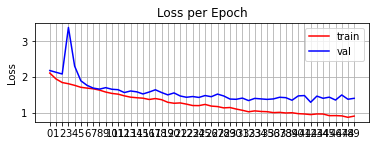

In [55]:
# TODO: fill in this code as you did above for the basic convolutional model
lr = 0.001
epochs = 50
model_unet = UNet(n_classes=len(classes)).to(device)
optimizer = torch.optim.AdamW(params=model_unet.parameters(), lr=lr)
model_unet = train(model_unet, optimizer, criterion, dataloader, device, val_loader=val_dataloader, num_epochs=epochs)

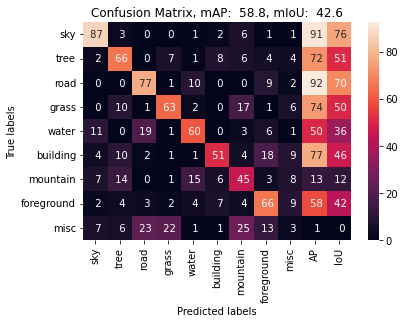

                 sky: AP: 0.91, IoU: 0.76
                tree: AP: 0.72, IoU: 0.51
                road: AP: 0.92, IoU: 0.70
               grass: AP: 0.74, IoU: 0.50
               water: AP: 0.50, IoU: 0.36
            building: AP: 0.77, IoU: 0.46
            mountain: AP: 0.13, IoU: 0.12
          foreground: AP: 0.58, IoU: 0.42
                misc: AP: 0.01, IoU: 0.00
                mean: AP: 0.59, IoU: 0.43


In [56]:
preds_unet, gts_unet = validate_model(val_dataloader, model_unet, list(dataset.classes), device, show_matrix=True)

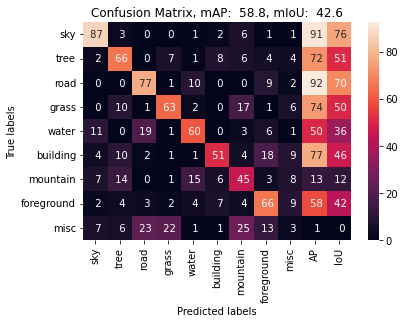

                 sky: AP: 0.91, IoU: 0.76
                tree: AP: 0.72, IoU: 0.51
                road: AP: 0.92, IoU: 0.70
               grass: AP: 0.74, IoU: 0.50
               water: AP: 0.50, IoU: 0.36
            building: AP: 0.77, IoU: 0.46
            mountain: AP: 0.13, IoU: 0.12
          foreground: AP: 0.58, IoU: 0.42
                misc: AP: 0.01, IoU: 0.00
                mean: AP: 0.59, IoU: 0.43


([0.913459612270221,
  0.719022087016934,
  0.9243104941868447,
  0.7359574057276915,
  0.5044193095769702,
  0.7720115672596837,
  0.12938518080188122,
  0.5803602734794152,
  0.009113253886793895],
 array([0.75786212, 0.50902193, 0.6998328 , 0.50467386, 0.35859441,
        0.46297773, 0.11915706, 0.42171814, 0.00418001]))

In [57]:
segmentation_eval(gts_unet, preds_unet, classes, '../results/unet_epoch-50.pdf')

Make sure to report the results for both models. 

## Working off a pretrained model (Q7)

Finally, you will now modify a pretrained model (resnet18) and use it as an initialization for training. You should be able to get better results with this model than before.

You can finetune (meaning backpropagate through the resnet layers) or not. You can finetune just some layers and not others. It's up to you.

**PDF: in your pdf report the final accuracy of your model based on a pretrained model. Describe how you used the pretrained model, which features did you extract and why?**

In [33]:
pretrained_resnet = models.resnet18(pretrained=True)

In [52]:
class ResnetBasedModel(nn.Module):

    def __init__(self, backbone, n_class):
        super().__init__()
        
        # You can, for example, extract the first N layers of the model like this:
        # self.resnet_features = nn.Sequential(*list(pretrained_resnet.children())[:N])
        # 10 layers in total and the first 8 layers are for feature extraction 
        self.backbone = list(backbone.children())
        
        self.conv = DoubleConv(3, 64) 
        self.layer0 = nn.Sequential(*self.backbone[:3]) # (N, 64, H / 2, W/2)
        self.layer1 = nn.Sequential(*self.backbone[3:5]) # (N, 64, H / 4, W/4)        
        self.layer2 = self.backbone[5]  # (N, 128, H / 8, W / 8)        
        self.layer3 = self.backbone[6]  # (N, 256, H / 16, W / 16)        
        self.layer4 = self.backbone[7]  # (N, 512, H / 32, W / 32)
                
        self.up4 = Up(512, 256)  # (N, 256, H / 16, W / 16)
        self.up3 = Up(256, 128)  # (N, 128, H / 8, W / 8)
        self.up2 = Up(128, 64)  # (N, 64, H / 4, W / 4)
        self.up1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # (N, 64, H / 2, W / 2)
        self.up0 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # (N, 32, H, W)
        
        self.clf = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            Conv1x1(64, n_class),
        )
        
    def forward(self, x):
        residual = self.conv(x)
        
        x0 = self.layer0(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        
        out = self.up4(x4, x3)
        out = self.up3(out, x2)
        out = self.up2(out, x1)
        out = self.up1(out)
        out = torch.cat([out, x0], dim=1)
        out = self.up0(out)
        out = torch.cat([out, residual], dim=1)
        
        out = self.clf(out)
        
        return out

In [53]:
resnet_based_model = ResnetBasedModel(pretrained_resnet, 9).to(device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1, training loss: 1.939
Epoch: 1, training loss: 2.103
Epoch: 2, training loss: 1.601
Epoch: 2, training loss: 1.772
Epoch: 3, training loss: 1.354
Epoch: 3, training loss: 1.492
Epoch: 4, training loss: 1.209
Epoch: 4, training loss: 1.404
Epoch: 5, training loss: 1.107
Epoch: 5, training loss: 1.293
Epoch: 6, training loss: 1.042
Epoch: 6, training loss: 1.248
Epoch: 7, training loss: 0.974
Epoch: 7, training loss: 1.171
Epoch: 8, training loss: 0.888
Epoch: 8, training loss: 1.138
Epoch: 9, training loss: 0.846
Epoch: 9, training loss: 1.180
Epoch: 10, training loss: 0.803
Epoch: 10, training loss: 1.057
Epoch: 11, training loss: 0.726
Epoch: 11, training loss: 1.080
Epoch: 12, training loss: 0.700
Epoch: 12, training loss: 1.030
Epoch: 13, training loss: 0.668
Epoch: 13, training loss: 1.145
Epoch: 14, training loss: 0.666
Epoch: 14, training loss: 1.104
Epoch: 15, training loss: 0.664
Epoch: 15, training loss: 1.055
Epoch: 16, training loss: 0.635
Epoch: 16, training loss: 

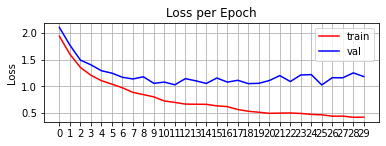

In [54]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(resnet_based_model.parameters(), lr=0.001)

for l in resnet_based_model.backbone:
    for param in l.parameters():
        param.requires_grad = False

resnet_based_model = train(resnet_based_model, optimizer, criterion, dataloader, device, val_loader=val_dataloader, num_epochs=30)

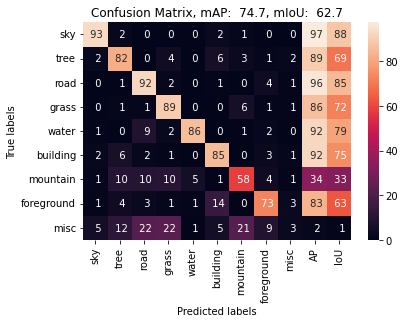

                 sky: AP: 0.97, IoU: 0.88
                tree: AP: 0.89, IoU: 0.69
                road: AP: 0.96, IoU: 0.85
               grass: AP: 0.86, IoU: 0.72
               water: AP: 0.92, IoU: 0.79
            building: AP: 0.92, IoU: 0.75
            mountain: AP: 0.34, IoU: 0.33
          foreground: AP: 0.83, IoU: 0.63
                misc: AP: 0.02, IoU: 0.01
                mean: AP: 0.75, IoU: 0.63


In [42]:
preds_resnet, gts_resnet = validate_model(val_dataloader, resnet_based_model, list(dataset.classes), device, show_matrix=True)

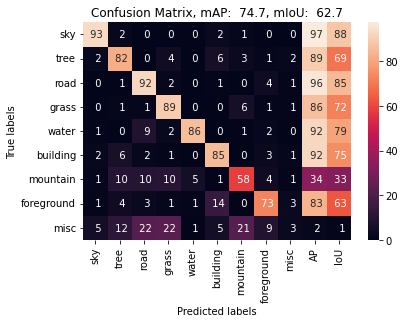

                 sky: AP: 0.97, IoU: 0.88
                tree: AP: 0.89, IoU: 0.69
                road: AP: 0.96, IoU: 0.85
               grass: AP: 0.86, IoU: 0.72
               water: AP: 0.92, IoU: 0.79
            building: AP: 0.92, IoU: 0.75
            mountain: AP: 0.34, IoU: 0.33
          foreground: AP: 0.83, IoU: 0.63
                misc: AP: 0.02, IoU: 0.01
                mean: AP: 0.75, IoU: 0.63


([0.9749624278360535,
  0.8939094401323997,
  0.9611541600175014,
  0.8620232350303602,
  0.9218798029662664,
  0.9220687290827461,
  0.3368710367854131,
  0.8316743135946755,
  0.01613768842952842],
 array([0.87969913, 0.69167308, 0.84802106, 0.71646071, 0.79451859,
        0.74543391, 0.32731945, 0.63004075, 0.01051642]))

In [43]:
segmentation_eval(gts_resnet, preds_resnet, classes, '../results/resnet-unet_epoch-30.pdf')

In [66]:
print(resnet_based_model)

ResnetBasedModel(
  (conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, mome

# Test set

Finally we can check evaluation on test set....

**PDF: in your pdf report the results of your best model (this should be based on a pretrained model) on the test dataset.**

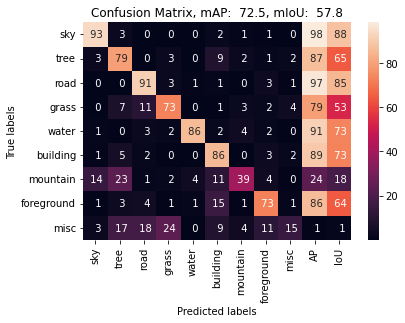

                 sky: AP: 0.98, IoU: 0.88
                tree: AP: 0.87, IoU: 0.65
                road: AP: 0.97, IoU: 0.85
               grass: AP: 0.79, IoU: 0.53
               water: AP: 0.91, IoU: 0.73
            building: AP: 0.89, IoU: 0.73
            mountain: AP: 0.24, IoU: 0.18
          foreground: AP: 0.86, IoU: 0.64
                misc: AP: 0.01, IoU: 0.01
                mean: AP: 0.72, IoU: 0.58


In [44]:
test_dataset = SegmentationDataset(split="test", preload=True, data_dir=DATASET_PATH, transform=False)
test_dataloader = data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, drop_last=False)
test_preds_resnet, test_gts_resnet = validate_model(test_dataloader, resnet_based_model, list(dataset.classes), device, show_matrix=True)

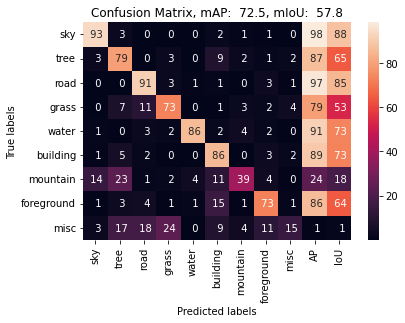

                 sky: AP: 0.98, IoU: 0.88
                tree: AP: 0.87, IoU: 0.65
                road: AP: 0.97, IoU: 0.85
               grass: AP: 0.79, IoU: 0.53
               water: AP: 0.91, IoU: 0.73
            building: AP: 0.89, IoU: 0.73
            mountain: AP: 0.24, IoU: 0.18
          foreground: AP: 0.86, IoU: 0.64
                misc: AP: 0.01, IoU: 0.01
                mean: AP: 0.72, IoU: 0.58


([0.9838340248087241,
  0.866167578859062,
  0.9691170901664091,
  0.7888369038025231,
  0.914121294283233,
  0.8942416041345054,
  0.2372309070889044,
  0.8638407553804327,
  0.0069815326742362],
 array([0.87967543, 0.64505004, 0.84950182, 0.52974299, 0.73122793,
        0.72907946, 0.1839585 , 0.64275449, 0.01450489]))

In [ ]:
segmentation_eval(test_gts_resnet, test_preds_resnet, classes, '../results/resnet-unet_epoch-30.pdf')